# Occupancy Hybrid Model

This notebook demonstrates a step-by-step workflow for building a hybrid model (combining Linear Regression and XGBoost) for Occupancy data. The process includes:

1. Data Import
2. Data Preprocessing & Feature Engineering
3. Train-Test Split
4. Model Training (Linear Regression and XGBoost)
5. Hybrid Prediction (averaging the predictions)
6. Evaluation

Customize the code as needed for your dataset.

In [20]:
# Import necessary libraries for HVAC modeling
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error

# For reproducibility
np.random.seed(42)

In [21]:
# Load the Occupancy data (ensure the file is in your working directory)
occupancy_data = pd.read_csv('occupancy_model_zones.csv')
print('Occupancy Data Shape:', occupancy_data.shape)
occupancy_data.head()

Occupancy Data Shape: (52561, 33)


,b'Environment:Site Outdoor Air Relative Humidity[%]',b'Environment:Site Outdoor Air Dewpoint Temperature[C]',b'Environment:Site Outdoor Air Wetbulb Temperature[C]',b'CLASSROOM_BOT ZN:Zone People Occupant Count[]',b'CONFROOM_BOT_1 ZN:Zone People Occupant Count[]',b'CONFROOM_BOT_2 ZN:Zone People Occupant Count[]',b'CONFROOM_MID_1 ZN:Zone People Occupant Count[]',b'CONFROOM_MID_2 ZN:Zone People Occupant Count[]',b'CONFROOM_TOP_1 ZN:Zone People Occupant Count[]',b'CONFROOM_TOP_2 ZN:Zone People Occupant Count[]',...,b'OPENOFFICE_MID_1 ZN:Zone People Occupant Count[]',b'OPENOFFICE_MID_2 ZN:Zone People Occupant Count[]',b'OPENOFFICE_MID_3 ZN:Zone People Occupant Count[]',b'OPENOFFICE_MID_4 ZN:Zone People Occupant Count[]',b'OPENOFFICE_TOP_1 ZN:Zone People Occupant Count[]',b'OPENOFFICE_TOP_2 ZN:Zone People Occupant Count[]',b'OPENOFFICE_TOP_3 ZN:Zone People Occupant Count[]',b'OPENOFFICE_TOP_4 ZN:Zone People Occupant Count[]',b'Environment:Site Day Type Index[]',b'Environment:Site Outdoor Air Drybulb Temperature[C]'
0,0.000000,0.00,0.000000,0.0,1.0,2.0,3.0,4.0,5.0,6.0,...,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,0.0,0.000000
1,83.666667,16.95,17.949119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,19.816667
2,84.333333,16.90,17.853131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,19.633333
3,85.000000,16.85,17.756143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,19.450000
4,85.666667,16.80,17.658150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,19.266667


In [22]:
occupancy_data.columns = occupancy_data.columns.str.replace(r"^b'|'$|\[.*?\]", "", regex=True)

In [23]:
occupancy_data = occupancy_data.loc[occupancy_data['Environment:Site Day Type Index'] != 0]

In [24]:
occupant_cols = [col for col in occupancy_data.columns if 'occupant' in str(col.lower())]
occupancy_data['total_occupants'] = occupancy_data[occupant_cols].sum(axis=1)
occupancy_data.drop(occupant_cols, axis=1, inplace=True)

In [25]:
start_datetime = pd.Timestamp(year=2004, month=1, day=1, hour=0, minute=0)

time_stamps = []
for i in range(len(occupancy_data)):
    current_time = start_datetime + pd.Timedelta(minutes=10 * i)
    time_stamps.append(current_time)
    
occupancy_data['timestamp'] = time_stamps

occupancy_data['timestamp'] = pd.to_datetime(occupancy_data['timestamp'])
occupancy_data['hour'] = occupancy_data['timestamp'].dt.hour
occupancy_data['day_of_week'] = occupancy_data['timestamp'].dt.dayofweek
occupancy_data['month'] = occupancy_data['timestamp'].dt.month

occupancy_data = occupancy_data.sort_values('timestamp')

In [26]:
# Shifts in hours
time_shifts = [0.5, 1, 1.5, 2]

# Create columns for each shift (backwards in time)
for h in time_shifts:
    steps = int(h * 6)  # for 10-min intervals
    occupancy_data[f"Occ_minus{int(h*60)}"] = occupancy_data["total_occupants"].shift(steps)

# If you also want future occupancy (Occ_plusXX), shift in the opposite direction:
for h in time_shifts:
    steps = int(h * 6)
    occupancy_data[f"Occ_plus{int(h*60)}"] = occupancy_data["total_occupants"].shift(-steps)

In [27]:
def map_day_type(x):
    # Common assumption: 0=Sunday, 6=Saturday, 7=Holiday => weekend/holiday
    if x in [0, 6, 7]:
        return 1
    else:
        return 0

occupancy_data["WeekendOrHoliday"] = occupancy_data["Environment:Site Day Type Index"].apply(map_day_type)

In [28]:
# Preprocessing and feature engineering for HVAC data
# (Customize this section according to your dataset requirements)
occupancy_data = occupancy_data.dropna()  # Example: drop missing values


# Define features and target; update column names as needed
features = [col for col in occupancy_data.columns if col not in ['total_occupants', 'timestamp']]
target = 'total_occupants'  # Replace with your actual target column name

In [29]:
def compute_metrics(test_data,forecast_mean):
    mae = mean_absolute_error(test_data, forecast_mean)
    mse = mean_squared_error(test_data, forecast_mean)
    rmse = np.sqrt(mse)


    metrics = {
        "mae":mae,
        "mse":mse,
        "rmse":rmse
    }

    return metrics

In [30]:
occupancy_data = occupancy_data[:int(len(occupancy_data)/16)]
print(occupancy_data.shape)

train_size = int(len(occupancy_data) * 0.8)
train_data = occupancy_data[:train_size]
test_data = occupancy_data[train_size:]

(3283, 19)


In [31]:
X_train, X_test = train_data[features], test_data[features]
y_train, y_test = train_data[target], test_data[target]

In [32]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_train_pred = linear_model.predict(X_train)
residuals_train = y_train.values - y_train_pred

In [33]:
lags = 5

X_train_resid = np.array([residuals_train[i - lags:i] for i in range(lags, len(residuals_train))])
y_train_resid = residuals_train[lags:]

xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, random_state=42)
xgb_model.fit(X_train_resid, y_train_resid)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [34]:
y_test_pred_linear = linear_model.predict(X_test)

residuals_test = y_test.values - y_test_pred_linear

X_test_resid = np.array([residuals_test[i - lags:i] for i in range(lags, len(residuals_test))])

resid_test_pred = xgb_model.predict(X_test_resid)

y_test_hybrid = y_test_pred_linear[lags:] + resid_test_pred

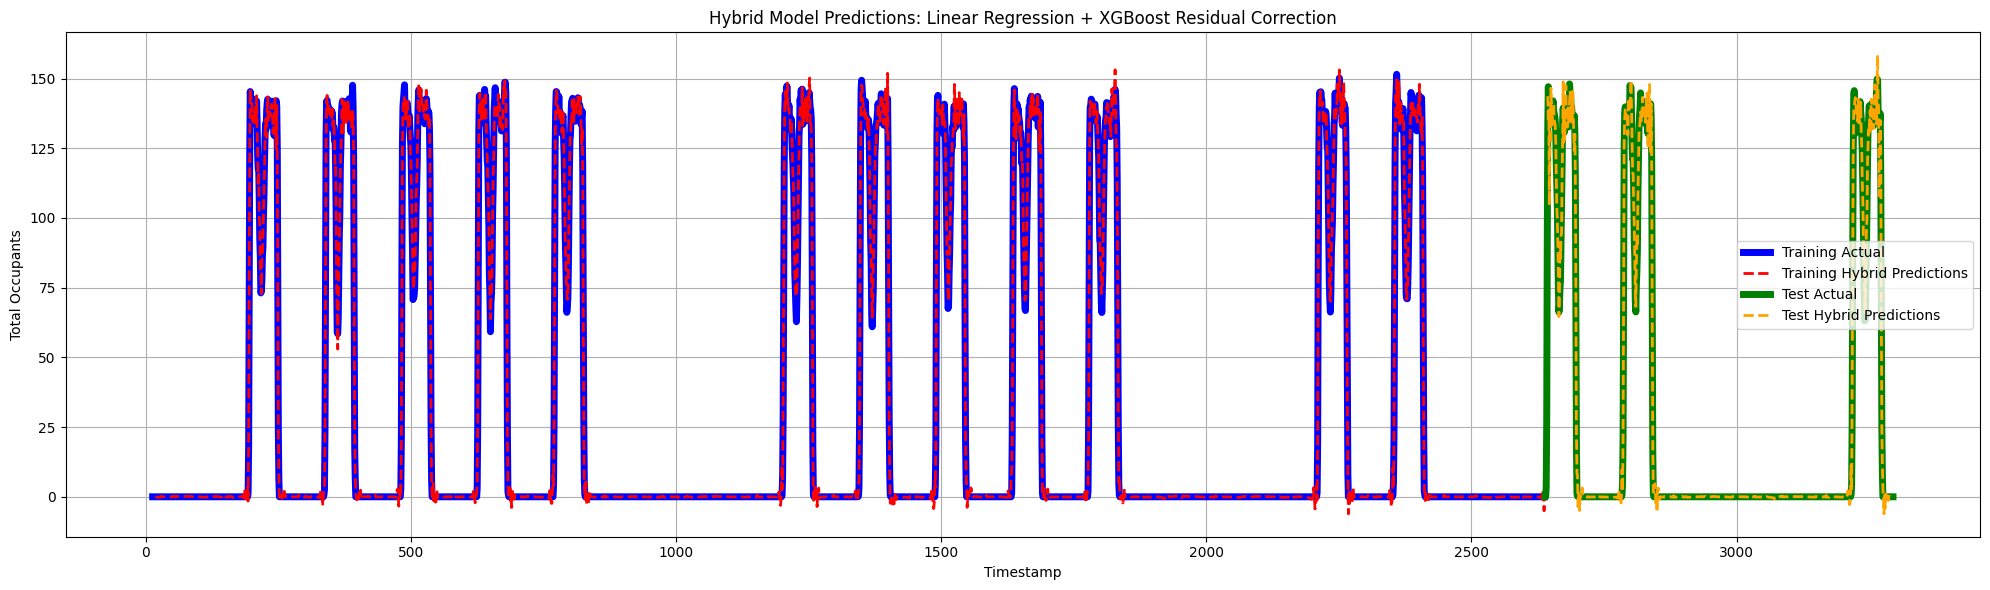

In [35]:


plt.figure(figsize=(20, 6))

X_train_resid_pred = np.array([residuals_train[i - lags:i] for i in range(lags, len(residuals_train))])
resid_train_pred = xgb_model.predict(X_train_resid_pred)
y_train_hybrid = y_train_pred[lags:] + resid_train_pred

plt.plot(y_train.index, y_train, label='Training Actual', color='blue', linewidth=5)
plt.plot(y_train.index[lags:], y_train_hybrid, label='Training Hybrid Predictions', color='red', linestyle='--', linewidth=2)

plt.plot(y_test.index, y_test, label='Test Actual', color='green', linewidth=5)
plt.plot(y_test.index[lags:], y_test_hybrid, label='Test Hybrid Predictions', color='orange', linestyle='--', linewidth=2)

plt.legend()
plt.title('Hybrid Model Predictions: Linear Regression + XGBoost Residual Correction')
plt.ylabel('Total Occupants')
plt.xlabel('Timestamp')
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:
metrics = compute_metrics(y_test.values[lags:], y_test_hybrid)
for key, value in metrics.items():
    print(f'{key}: {value}')

mae: 1.4708552697990167
mse: 12.39635288183648
rmse: 3.5208454782674687


In [37]:
Occupancy_Model.ipynb

NameError: name 'Occupancy_Model' is not defined